In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [3]:
def TDMASolve(a, b, c, d):
  nmax = len(d)#n em números é linhass

  # Modifica o primeiro coeficiente de cada linha
  c[0] /= b[0] #Risco de divisão por zero.
  d[0] /= b[0]

  for i in range(1, nmax):
    ptemp = b[i] - (a[i] * c[i-1])
    c[i] /= ptemp
    d[i] = (d[i] - a[i] * d[i-1])/ptemp

  #Substituição de volta
  x = [0 for i in range(nmax)]
  x[-1] = d[-1]
  for i in range(-2,-nmax-1,-1):
    x[i] = d[i] - c[i] * x[i+1]
  return x

In [99]:
def norma_maximo(aprox, exata):
  return max(abs(exata - aprox))

def norma_maximo2(aprox, exata, nel):
  u = []
  for i in range(nel):
    for j in range(nel):
      u.append(abs(aprox[i,j] - exata[i,j]))
  return max(u)

def taxaconvergencia(erro, numpoints):
  taxa = []
  for i in range(0, len(numpoints)-1):
      taxa.append(abs(np.log2(erro[i+1]) - np.log2(erro[i])) / (np.log2(numpoints[i+1]) - np.log2(numpoints[i])))
  return max(taxa)


In [5]:
def exata1(eps, t, x, y):
  return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)*np.sin(np.pi*y)

def exata2(eps, t, x, y):
  xtraco = x*np.cos(4*t) + y*np.sin(4*t)
  ytraco = -x*np.sin(4*t) + y*np.cos(4*t)
  xc = 0.2
  yc = 0
  gama = 0.1

  return ((2*gama*gama)/(2*gama*gama + 4*eps*t))*np.exp(-((xtraco-xc)**2 + (ytraco-yc)**2)/(2*gama*gama+(4*eps*t)))


In [83]:

#Função:::
def ADI_upwind(eps, kappa, xi, xf, nel, ti, tf, condcontorno,elevado):
  # espaçamento entre os elementos
  h = (xf-xi)/nel
  h2 = h*h
  #espaçamento temporal
  dt = h**elevado
  sigma = eps*dt/h2

  x = np.linspace(xi,xf,nel+1)
  y = np.linspace(xi,xf,nel+1)

  ux = np.zeros((nel+1,nel+1))
  uy = np.zeros((nel+1,nel+1))

  #condicao inicial
  for i in range(0,nel+1):
    for j in range(0,nel+1):
      uy[i,j] = condcontorno(eps,ti,x[i],y[j])

  t = ti
  b1,b2= kappa(x, y) #b1 e b2 são vetores
  while(t < tf):

  #### PRIMEIRO PASSO ####
    t = t + dt/2
  #condicoes de contorno de Dirichlet
    ux[0,:] = condcontorno(eps,t,x[0],y[:])
    ux[nel,:] = condcontorno(eps,t,x[nel],y[:])
    ux[:,0] = condcontorno(eps,t,x[:],y[0])
    ux[:,nel] = condcontorno(eps,t,x[:],y[nel])
    for j in range(1,nel):
      #construcao da matriz
      ro1 = b1[j]*dt/(2*h)
      a = np.ones(nel-1) * ((-sigma/2) + (b1[j]>0)*(-ro1)) #i-1
      b = np.ones(nel-1) * ((1+sigma) + (b1[j]>0)*(ro1) + (b1[j]<0)*(-ro1)) #i
      c = np.ones(nel-1) * ((-sigma/2) + (b1[j]<0)*(ro1)) #i+1

      # construcao do vetor fonte
      d = (1 - sigma)*uy[1:nel,j] + sigma/2*(uy[1:nel,j+1] + uy[1:nel,j-1]) - (b2[1:nel]>0)*((b2[1:nel]*dt/(2*h))*(uy[1:nel,j] - uy[1:nel,j-1])) - (b2[1:nel]<0)*((b2[1:nel]*dt/(2*h))*(uy[1:nel,j+1]-uy[1:nel,j]))

      # contribuicao das condicoes de contorno no termo fonte
      d[0] = d[0] + sigma/2*ux[0,j] + (b1[j]>0)*(ro1)*ux[0,j]
      d[nel-2] = d[nel-2] + sigma/2*ux[nel,j] - (b1[j]<0)*(ro1)*ux[nel,j]

      ux[1:nel,j] = TDMASolve(a,b,c,d)

  #### SEGUNDO PASSO ####
    t = t + dt/2
  #condicoes de contorno de Dirichlet
    uy[0,:] = condcontorno(eps,t,x[0],y[:])
    uy[nel,:] = condcontorno(eps,t,x[nel],y[:])
    uy[:,0] = condcontorno(eps,t,x[:],y[0])
    uy[:,nel] = condcontorno(eps,t,x[:],y[nel])
    for i in range(1,nel):
      #construcao da matriz
      ro2 = b2[i]*dt/(2*h)
      a = np.ones(nel-1)*((-sigma/2) + (b2[i]>0)*(-ro2))
      b = np.ones(nel-1)*((1+sigma) + (b2[i]>0)*(ro2) + (b2[i]<0)*(-ro2))
      c = np.ones(nel-1)*((-sigma/2) + (b2[i]<0)*(ro2))
      # construcao do vetor fonte
      d = (1 - sigma)*ux[i,1:nel] + sigma/2*(ux[i+1,1:nel] + ux[i-1,1:nel]) - (b1[1:nel]>0)*((b1[1:nel]*dt/(2*h))*(ux[i,1:nel] - ux[i-1,1:nel])) - (b1[1:nel]<0)*((b1[1:nel]*dt/(2*h)) *(ux[i+1,1:nel]-ux[i,1:nel]))

      # contribuicao das condicoes de contorno no termo fonte
      d[0] = d[0] + sigma/2*uy[i,0] + (b2[i]>0)*(ro2)*uy[i,0]
      d[nel-2] = d[nel-2] + sigma/2*uy[i,nel] - (b2[i]<0)*(ro2)*uy[i,nel]

      uy[i,1:nel] = TDMASolve(a,b,c,d)

  return uy, x, y

#Primeira Questão

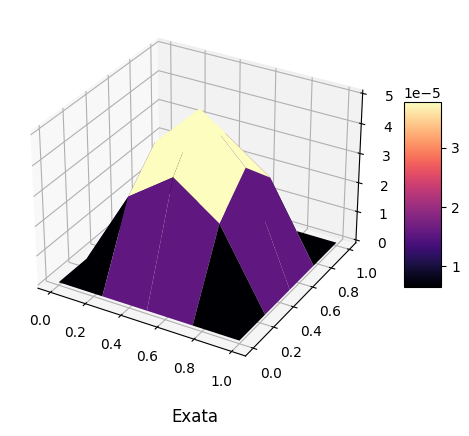

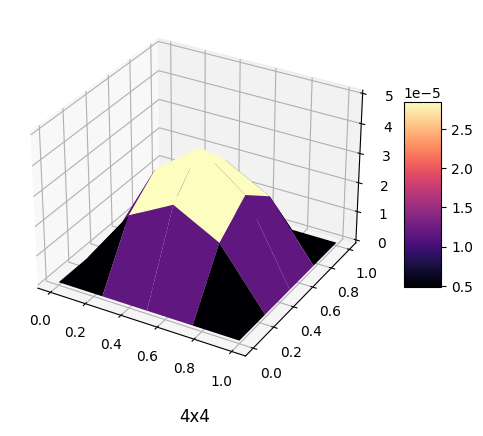

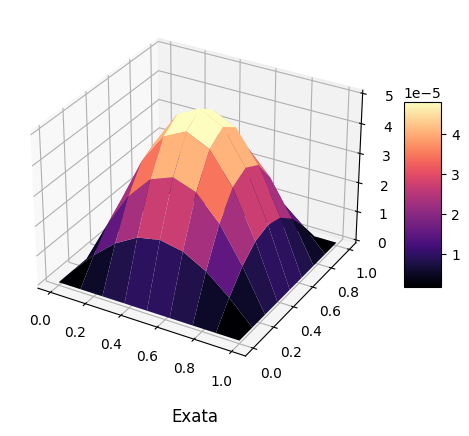

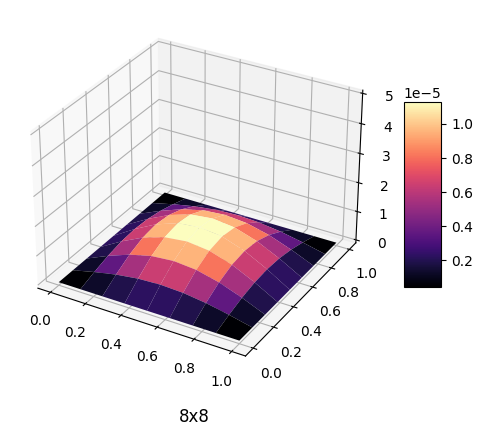

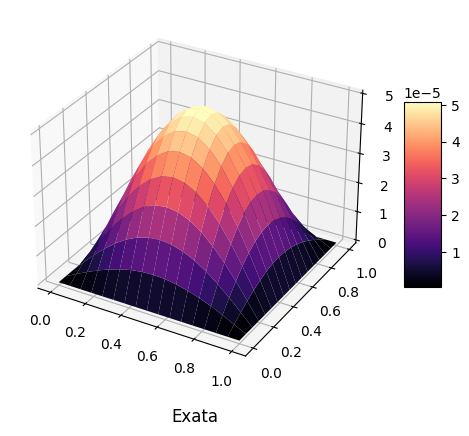

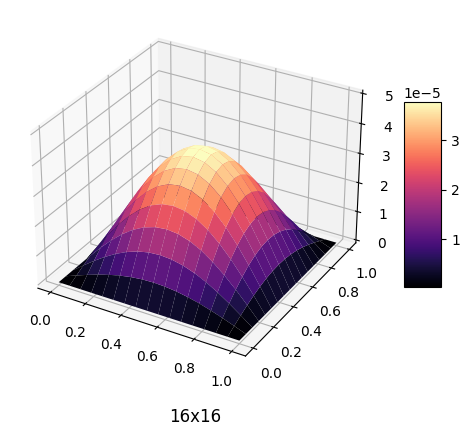

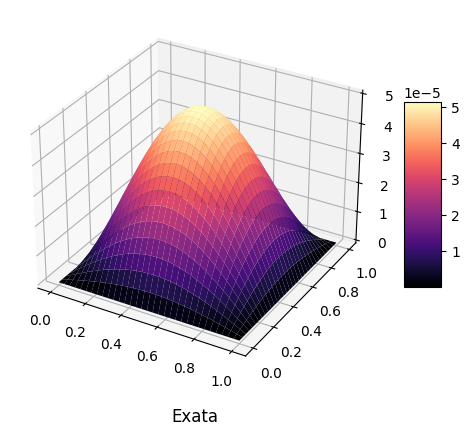

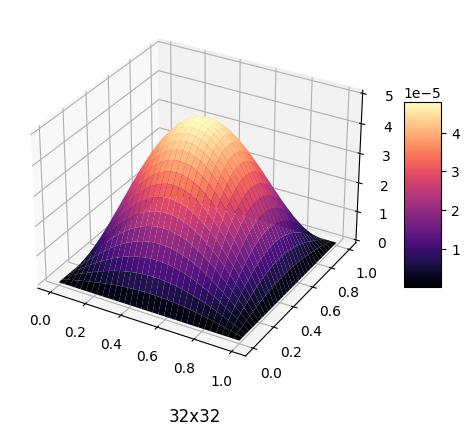

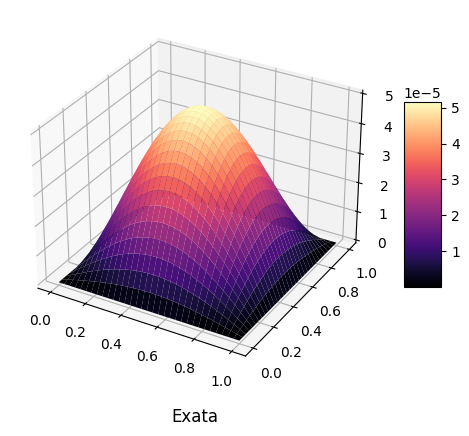

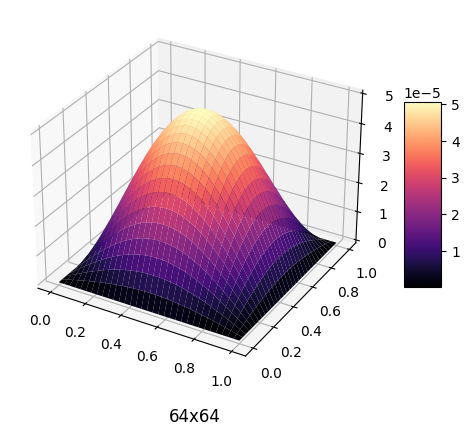

Taxa convergência: 1.976092267104569


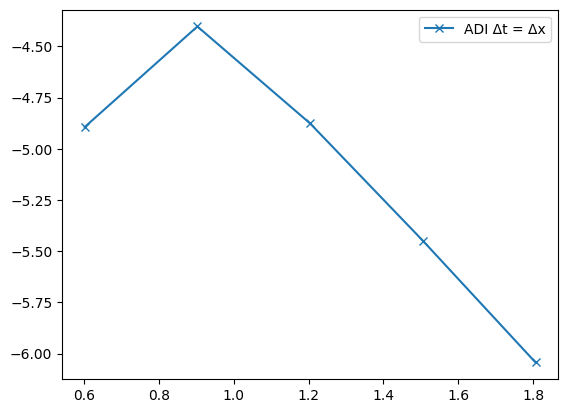

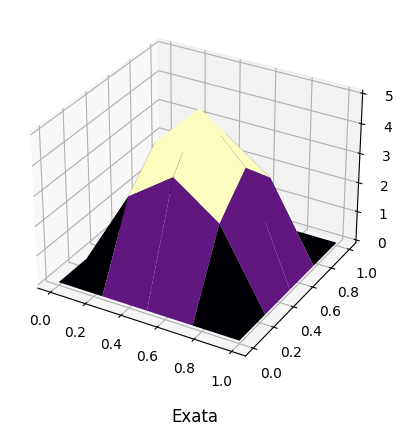

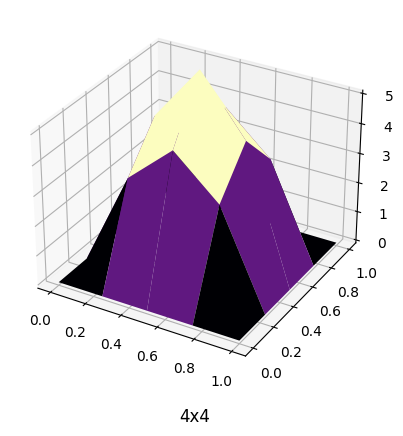

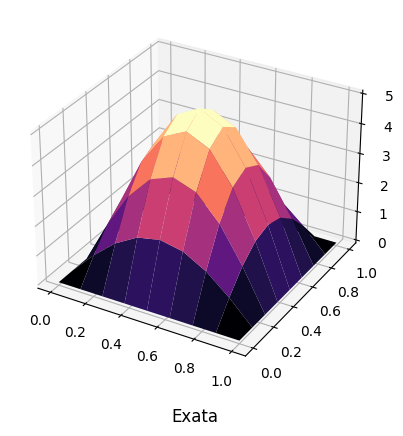

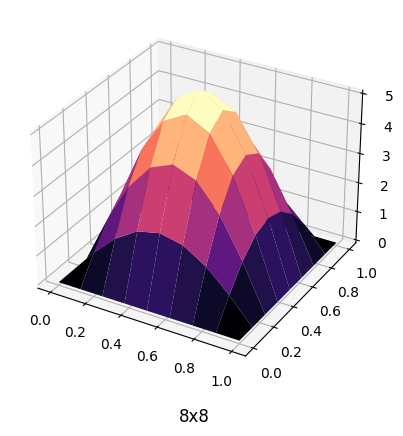

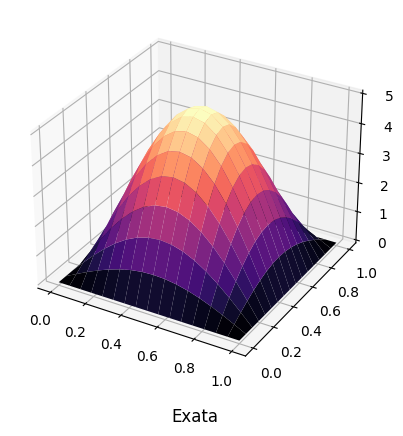

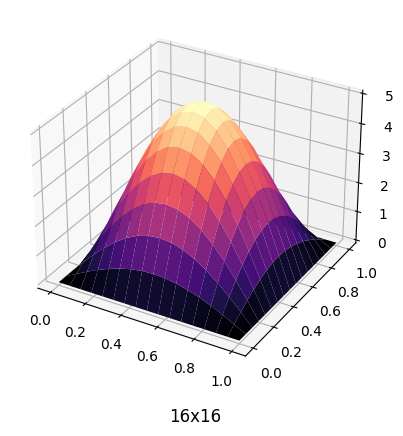

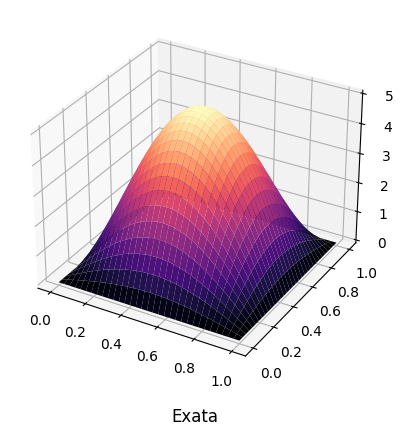

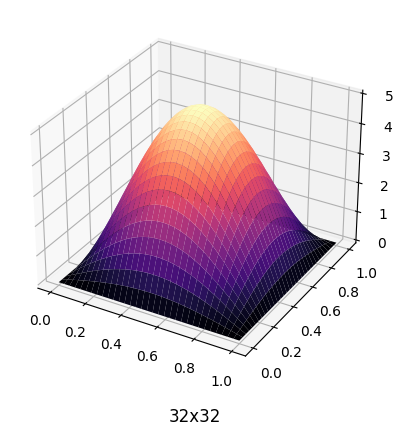

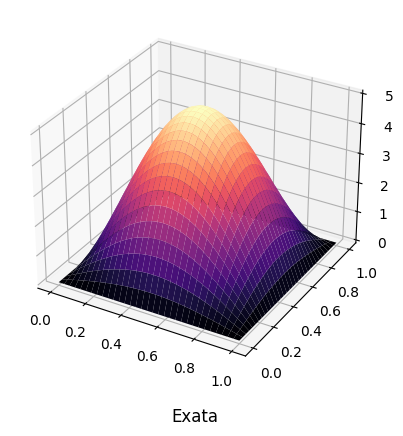

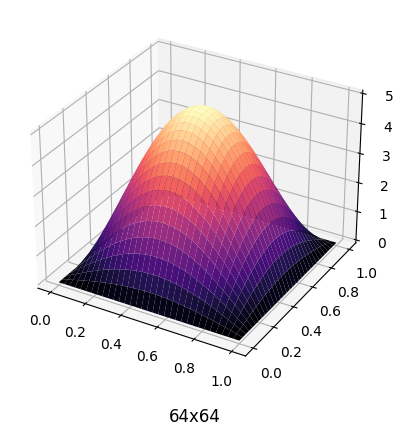

' print("Taxa convergência: "  + str(taxaconvergencia(erros, npoints)))\nplt.plot(np.log10(npoints), np.log10(erros), "-x", label="ADI Δt = Δx²")\nplt.legend()\nplt.xlabel("log₁₀(número de pontos)")\nplt.ylabel("log₁₀(erro)")\nplt.show()   '

In [106]:
#Parâmetros
nel = 64

# dominio espacial
xi = 0
xf = 1
#dominio temporal
ti = 0
tf = 0.5
#coeficiente difusivo
eps = 1
#eps = 0.1

def kappa2(x, y):
  b1 = -4*y
  b2 = 4*x
  return b1, b2

def kappa1(x,y):
  b1 = 0.0*x
  b2 = 0.0*y
  return b1, b2
erros = []
npoints = []

for i in range(2,7):
  nel = 2**i
  npoints.append(nel)
  uy,x,y = ADI_upwind(nel=nel, xi=xi, xf=xf, tf=tf, ti=ti, eps=eps, kappa=kappa1, condcontorno=exata1, elevado=1)

  X,Y = np.meshgrid(x,y)
  zs = np.array(exata1(eps,tf,np.ravel(X), np.ravel(Y)))
  ZZ = zs.reshape(Y.shape)
  gg = np.array(exata1(eps,tf, np.ravel(Y), np.ravel(X)))
  JJ = gg.reshape(Y.shape)
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1, projection='3d')
  ax.set_zlim3d(0,5*(10**(-5)))
  surf = ax.plot_surface(X, Y, ZZ, cmap=cm.magma)
  plt.title('Exata', y=-0.15)
  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(1,1,1, projection='3d')
  surf = ax.plot_surface(Y, X, uy,cmap=cm.magma)
  plt.title(str(nel) + "x" + str(nel),y=-0.15)
  ax.set_zlim3d(0,5*(10**(-5)))
  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.show()

  erros.append(norma_maximo2(uy, JJ, nel))


''' print("Taxa convergência: "  + str(taxaconvergencia(erros, npoints)))
plt.plot(np.log10(npoints), np.log10(erros), "-x", label="ADI Δt = Δx")
plt.legend()
plt.show() '''

erros.clear()
npoints.clear()

for i in range(2,7):
  nel = 2**i
  npoints.append(nel)
  uy,x,y = ADI_upwind(nel=nel, xi=xi, xf=xf, tf=tf, ti=ti, eps=eps, kappa=kappa1, condcontorno=exata1, elevado=2)

  X,Y = np.meshgrid(x,y)
  zs = np.array(exata1(eps,tf,np.ravel(X), np.ravel(Y)))
  ZZ = zs.reshape(Y.shape)

  gg = np.array(exata2(eps,tf, np.ravel(Y), np.ravel(X)))
  JJ = gg.reshape(Y.shape)


  fig = plt.figure()
  ax = fig.add_subplot(1,1,1, projection='3d')
  ax.set_zlim3d(0,5*(10**(-5)))
  surf = ax.plot_surface(X, Y, ZZ, cmap=cm.magma)

  # Add a color bar which maps values to colors.
  plt.title('Exata', y=-0.15)
  plt.show()
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1, projection='3d')
  surf = ax.plot_surface(X, Y, uy,cmap=cm.magma)
  plt.title(str(nel) + "x" + str(nel),y=-0.15)
  ax.set_zlim3d(0,5*(10**(-5)))

  erros.append(norma_maximo2(uy, ZZ, nel))


  plt.show()

''' print("Taxa convergência: "  + str(taxaconvergencia(erros, npoints)))
plt.plot(np.log10(npoints), np.log10(erros), "-x", label="ADI Δt = Δx²")
plt.legend()
plt.xlabel("log₁₀(número de pontos)")
plt.ylabel("log₁₀(erro)")
plt.show()   '''

#Segunda questão

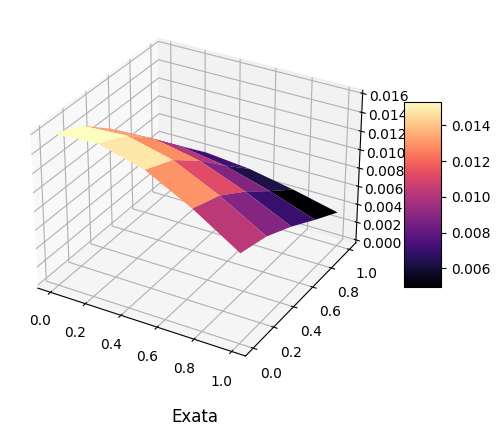

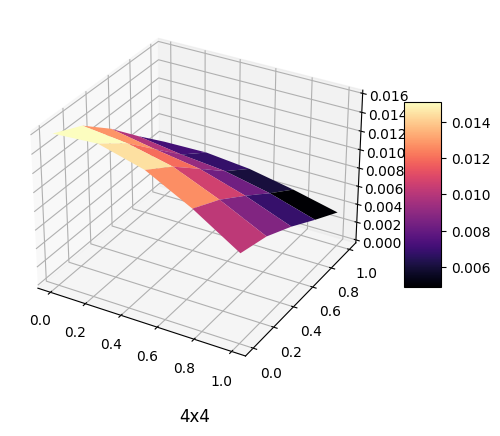

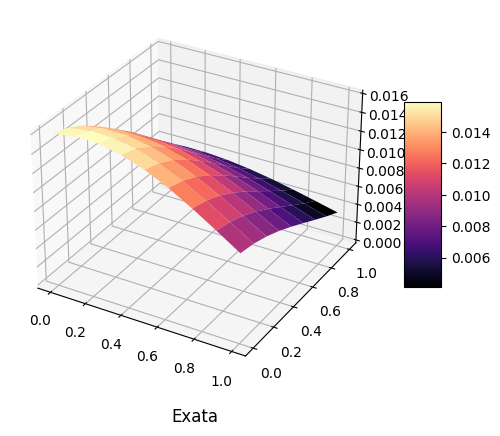

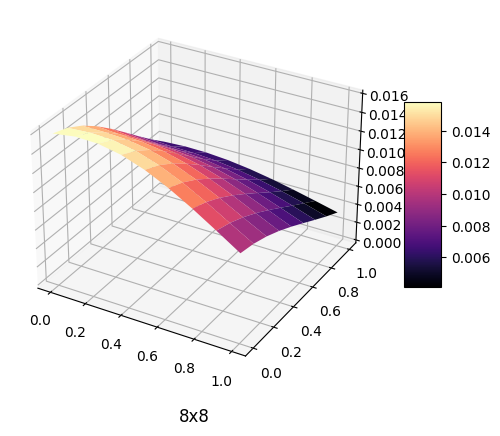

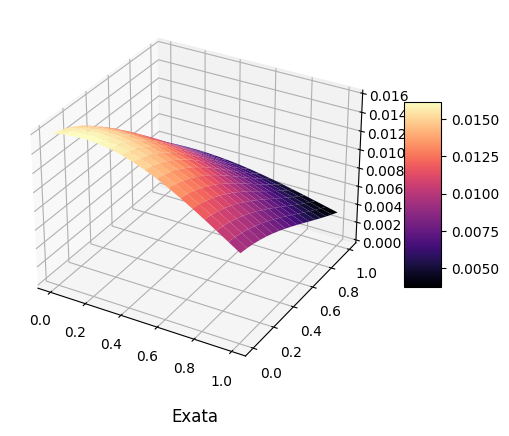

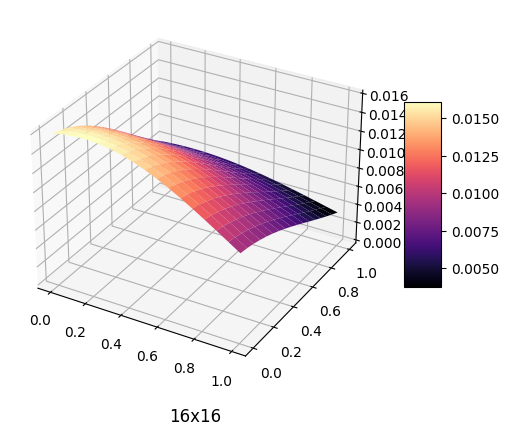

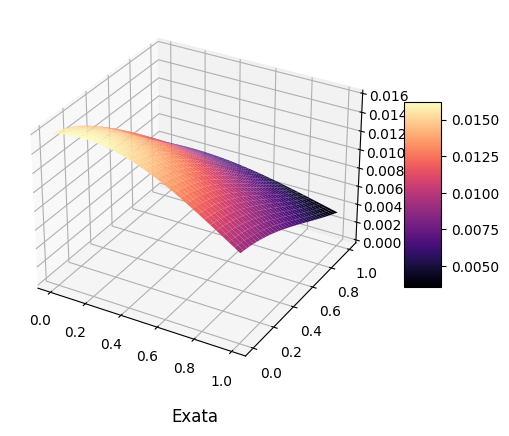

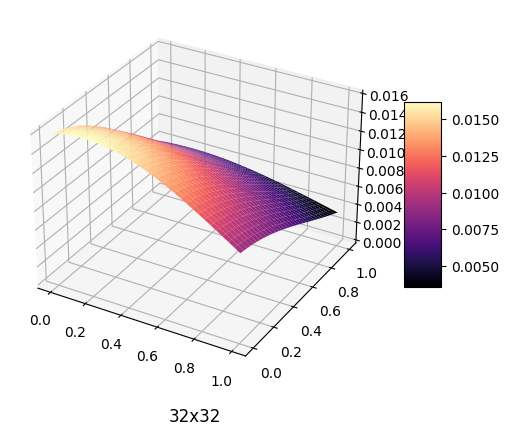

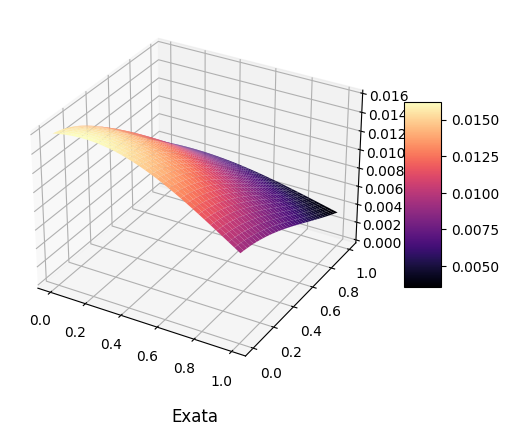

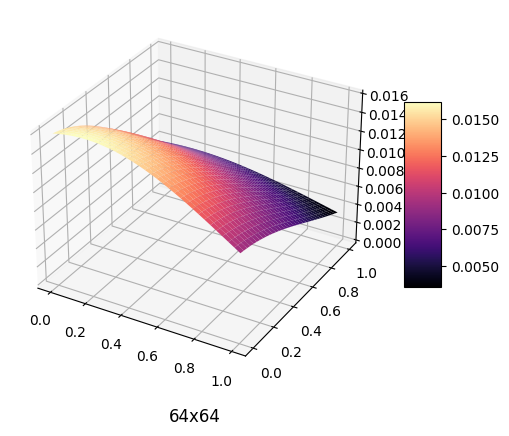

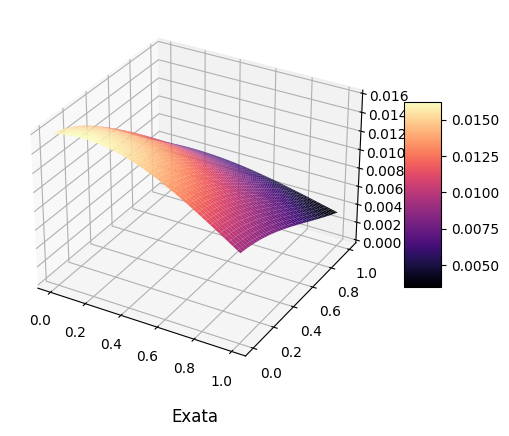

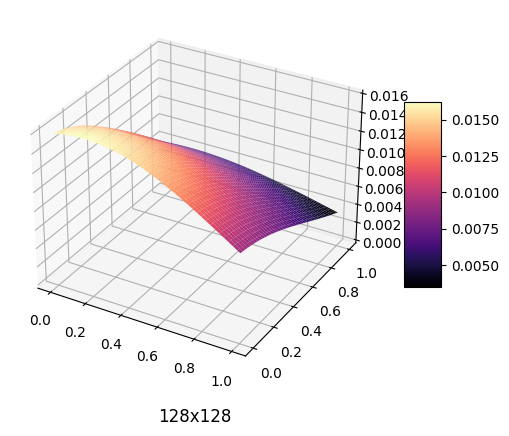

Taxa convergência: 0.9800955304683914


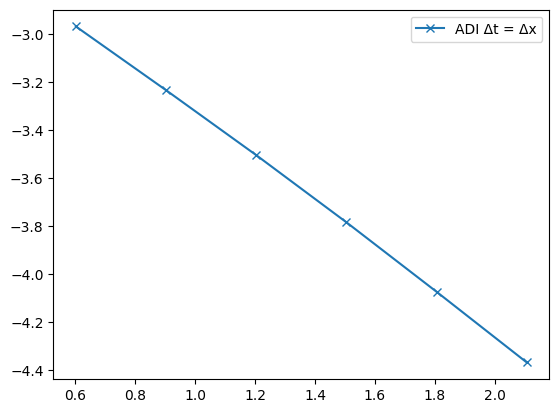

' \nfor i in range(2,7):\n  nel = 2**i\n  npoints.append(nel)\n  uy,x,y = ADI_upwind(nel=nel, xi=xi, xf=xf, tf=tf, ti=ti, eps=eps, kappa=kappa2, condcontorno=exata2, elevado=2)\n\n  X,Y = np.meshgrid(x,y)\n  zs = np.array(exata1(eps,tf,np.ravel(X), np.ravel(Y)))\n  ZZ = zs.reshape(Y.shape)\n\n  gg = np.array(exata2(eps,tf, np.ravel(Y), np.ravel(X)))\n  JJ = gg.reshape(Y.shape)\n\n  \n  fig = plt.figure()\n  ax = fig.add_subplot(1,1,1, projection=\'3d\')\n  ax.set_zlim3d(0,5*(10**(-5)))\n  surf = ax.plot_surface(X, Y, ZZ, cmap=cm.magma)\n\n  # Add a color bar which maps values to colors.\n  plt.title(\'Exata\', y=-0.15)\n  plt.show() \n  fig = plt.figure()\n  ax = fig.add_subplot(1,1,1, projection=\'3d\')\n  surf = ax.plot_surface(X, Y, uy,cmap=cm.magma)\n  plt.title(str(nel) + "x" + str(nel),y=-0.15)\n  ax.set_zlim3d(0,5*(10**(-5)))  \n\n  erros.append(norma_maximo2(uy, ZZ, nel))\n\n\n  # plt.show()\n\nprint("Taxa convergência: "  + str(taxaconvergencia(erros, npoints)))\nplt.plot(np.l

In [100]:
#Parâmetros
nel = 64

# dominio espacial
xi = 0
xf = 1
#dominio temporal
ti = 0
tf = 3
#coeficiente difusivo
#eps = 1
eps = 0.1

def kappa2(x, y):
  b1 = -4*y
  b2 = 4*x
  return b1, b2

def kappa1(x,y):
  b1 = 0.0*x
  b2 = 0.0*y
  return b1, b2
erros = []
npoints = []

for i in range(2,8):
  nel = 2**i
  npoints.append(nel)
  uy,x,y = ADI_upwind(nel=nel, xi=xi, xf=xf, tf=tf, ti=ti, eps=eps, kappa=kappa2, condcontorno=exata2, elevado=1)

  X,Y = np.meshgrid(x,y)
  zs = np.array(exata2(eps,tf,np.ravel(X), np.ravel(Y)))
  ZZ = zs.reshape(Y.shape)

  gg = np.array(exata2(eps,tf, np.ravel(Y), np.ravel(X)))
  JJ = gg.reshape(Y.shape)

  fig = plt.figure()
  ax = fig.add_subplot(1,1,1, projection='3d')
  # ax.set_zlim3d(0,5*(10**(-5)))
  ax.set_zlim3d(0,0.016)

  surf = ax.plot_surface(X, Y, ZZ, cmap=cm.magma)
  plt.title('Exata', y=-0.15)

  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(1,1,1, projection='3d')
  surf = ax.plot_surface(Y, X, uy,cmap=cm.magma)
  plt.title(str(nel) + "x" + str(nel),y=-0.15)
  # ax.set_zlim3d(0,5*(10**(-5)))
  ax.set_zlim3d(0,0.016)
  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.show()

  erros.append(norma_maximo2(uy, JJ, nel))


print("Taxa convergência: "  + str(taxaconvergencia(erros, npoints)))
plt.plot(np.log10(npoints), np.log10(erros), "-x", label="ADI Δt = Δx")
plt.legend()
plt.show()

erros.clear()
npoints.clear()
